# iSCM Tutorial

This notebook provides examples of how to sample from internally standardized structural causal models (iSCMs) using the `iscm` library. If you are looking for a ready-to-use code snippet for sampling, take a look at the **TL;DR** section. Otherwise, this notebook walks you through other library functionalities, such as creating and sampling graphs, sampling from SCMs, standardized SCMs, and iSCMs.


  

## Setup

In [1]:
!pip install iscm

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from iscm import graph_utils, data_sampler, graph_sampler

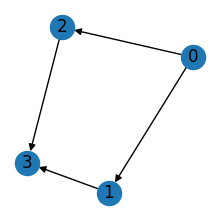

In [20]:
# Sample from an iSCM
NUM_NODES = 20
EDGES_PER_NODE = 2
WEIGHT_RANGE = (0.5, 2.0) # The weights will be sampled randomly from ± weight range (so excluding the range around 0)
NOISE_DISTRIBUTION = data_sampler.GAUSSIAN
NOISE_VARIANCE = 10e-5

SAMPLE_SIZE = 100
SEED = 0

rng = np.random.default_rng(seed=SEED)

do_intervention_dict = {
    2: 0.9,
    1: 0.7,
}

graph_matrix = graph_utils.Graph(
    weight_matrix = np.array([
        [0.0, 1.5, 2.0, 0.0],
        [0.0, 0.0, 0.0, 3.0],
        [0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0],
    ])
)

plt.figure(figsize=(2, 2))
nx.draw(graph_matrix.get_nx_graph(), with_labels=True)
plt.show()

iscm_sample = data_sampler.sample_linear(
                graph=graph_matrix,
                do_interventions=do_intervention_dict,
                noise_variance=NOISE_VARIANCE,
                standardization="internal",
                sample_size=SAMPLE_SIZE,
                noise_distribution=NOISE_DISTRIBUTION,
                rng=rng,
              )

In [21]:
# only show few decimals
np.set_printoptions(precision=7, suppress=True)
print("Sampled data:")
print(iscm_sample[:5])

Sampled data:
[[ 0.0461578  0.0498274  0.9        0.0480776]
 [-0.2204824 -0.2134671  0.9       -0.2150611]
 [ 0.5784271  0.5774521  0.9        0.5725861]
 [ 0.0246163  0.0177843  0.9        0.0206763]
 [-0.6378288 -0.6314342  0.9       -0.6283142]]


## TLDR;
To generate data from a linear iSCM with a random 20-node Erdos-Renyi graph, simply run:

In [2]:
rng = np.random.default_rng(seed=0)

# Generate a graph
graph = graph_sampler.generate_erdos_renyi_graph(
            num_nodes=20,
            edges_per_node=2,
            weight_range=(0.5, 2.0), # The weights will be sampled randomly from ± weight range (so excluding the range around 0)
            rng=rng,
        )

iscm_sample = data_sampler.sample_linear(
                  graph=graph,
                  sample_size=100,
                  standardization='internal',
                  rng=rng,
              )

In [3]:
iscm_sample.shape # Rows represent samples and collumns represent variables

(100, 20)

## Library features

### Creating graphs

As you might have noticed in the TLDR; section, before generating the data we need to define a directed graph. We can either manually define a specifc graph or sample it from common graph families.

#### Manually defining a graph

We can manually define a graph using three formats: a weight matrix, a weight dictionary or an edge list.

In [31]:
graph_matrix = graph_utils.Graph(
    weight_matrix = np.array([
        [0.0, 1.5, 2.0, 0.0],
        [0.0, 0.0, 0.0, 3.0],
        [0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0],
    ])
)

In [27]:
graph_matrix.get_json_dict()

{'(0, 0)': np.float64(1.0),
 '(0, 1)': np.float64(1.5),
 '(1, 1)': np.float64(0.2),
 '(1, 3)': np.float64(3.0),
 '(2, 2)': np.float64(0.5),
 '(2, 3)': np.float64(1.5),
 '(3, 3)': np.float64(2.0)}

In [5]:
graph_weight_dict = graph_utils.Graph(
    weight_dict = {
        (0, 1): 1.5,
        (1, 2): 2.0
    }
)

In [6]:
# Warning: The edge list format doesn't allow for specifying the weights
graph_edge_list = graph_utils.Graph(
    schema = [(0, 1), (1, 2)]
)

All the above examples create an object of `graph_utils.Graph` class.

In [7]:
print(graph_matrix)
print(graph_weight_dict)
print(graph_edge_list)

The `graph_utils.Graph` can be easily converted into a `networkx` object and drawn.

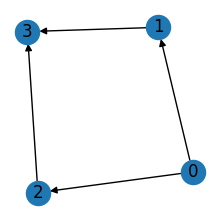

In [32]:
plt.figure(figsize=(2, 2))
nx.draw(graph_matrix.get_nx_graph(), with_labels=True)
plt.show()

The library supports several useful operations on the `graph_utils.Graph` class. Example operations include getting the children or parents of specific nodes, checking if the graph has cycles, or topologically sorting a DAG. For a complete list of supported features, see the [graph_utils.py](https://github.com/werkaaa/iscm/blob/main/iscm/graph_utils.py) file.

In [9]:
print(graph_matrix.get_children(0)) # Finding children of node 0
print(graph_matrix.get_parents(1)) # Finding parents of node 1
print(graph_utils.has_cycles(graph_matrix)) # Checking the graph for cycles
print(graph_utils.topo_sort(graph_matrix)) # Topologically sorting the graph

[1]
[0]
False
[0, 1, 2]


#### Sampling a graph

The library supports sampling random Erdős-Rényi and scale-free graphs.

In [33]:
NUM_NODES = 10
EDGES_PER_NODE = 2
WEIGHT_RANGE = (0.5, 2.0) # The weights will be sampled randomly from ± weight range (so excluding the range around 0)
SEED = 0

In [11]:
# Erdős–Rényi graph
graph_er = graph_sampler.sample_erdos_renyi(
              num_nodes=NUM_NODES,
              edges_per_node=EDGES_PER_NODE,
              weight_range=WEIGHT_RANGE,
              rng=rng,
            )

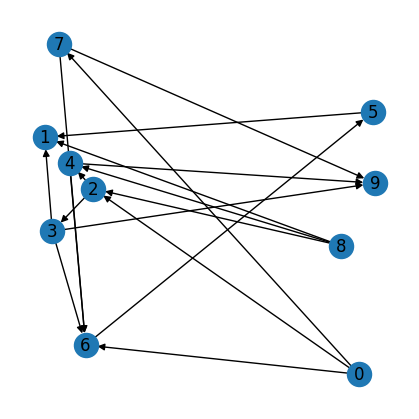

In [13]:
plt.figure(figsize=(4, 4))
nx.draw(graph_er.get_nx_graph(), with_labels=True)
plt.show()

In [34]:
# Scale free graph (sample undirected and randomly direct the edges)
graph_usf = graph_sampler.sample_scale_free(
                num_nodes=NUM_NODES,
                edges_per_node=EDGES_PER_NODE,
                direct_graph_post_sampling=True,
                weight_range=WEIGHT_RANGE,
                rng=rng,
            )

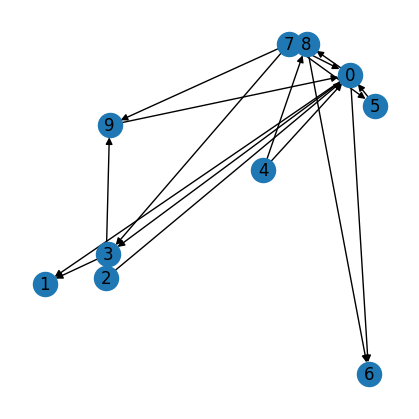

In [13]:
plt.figure(figsize=(4, 4))
nx.draw(graph_usf.get_nx_graph(), with_labels=True)
plt.show()

In [14]:
# Scale free graph (sample directed)
graph_sf = graph_sampler.sample_scale_free(
              num_nodes=NUM_NODES,
              edges_per_node=EDGES_PER_NODE,
              direct_graph_post_sampling=False,
              weight_range=WEIGHT_RANGE,
              rng=rng,
            )

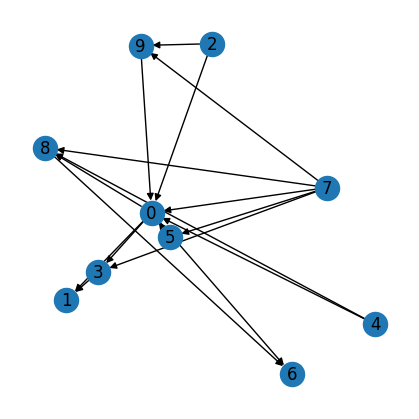

In [15]:
plt.figure(figsize=(4, 4))
nx.draw(graph_usf.get_nx_graph(), with_labels=True)
plt.show()

## Sampling
Having defined the graph, we can now sample data.

In [22]:
NUM_NODES = 20
EDGES_PER_NODE = 2
WEIGHT_RANGE = (0.5, 2.0) # The weights will be sampled randomly from ± weight range (so excluding the range around 0)
NOISE_DISTRIBUTION = data_sampler.GAUSSIAN
NOISE_VARIANCE = 1.0

SAMPLE_SIZE = 100
SEED = 0

rng = np.random.default_rng(seed=SEED)

# Generate a graph
graph = graph_sampler.generate_erdos_renyi_graph(
          num_nodes=NUM_NODES,
          edges_per_node=EDGES_PER_NODE,
          weight_range=WEIGHT_RANGE,
          rng=rng,
        )


### Linear

The library supports sampling from linear iSCMs, standardized SCMs (where the standardization is performed on the fly based on the empirical estimates of the mean and standard deviation of each node) and SCMs.

In [35]:
# Sample from an iSCM
# dictionary for do-intervention
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from iscm import graph_utils, data_sampler, graph_sampler

do_intervention_dict = {
    0: 0.5,
    1: 0.5,
}

iscm_sample = data_sampler.sample_linear(
                graph=graph_matrix,
                do_intervention_dict=do_intervention_dict,
                noise_variance=NOISE_VARIANCE,
                standardization='internal',
                sample_size=SAMPLE_SIZE,
                noise_distribution=NOISE_DISTRIBUTION,
                rng=rng,
              )

In [20]:
# Sample from a standardized SCM
sscm_sample = data_sampler.sample_linear(
                graph=graph,
                noise_variance=NOISE_VARIANCE,
                standardization='naive',
                sample_size=SAMPLE_SIZE,
                noise_distribution=NOISE_DISTRIBUTION,
                rng=rng,
              )

In [21]:
# Sample from an SCM
scm_sample = data_sampler.sample_linear(
                graph=graph,
                noise_variance=NOISE_VARIANCE,
                standardization=None,
                sample_size=SAMPLE_SIZE,
                noise_distribution=NOISE_DISTRIBUTION,
                rng=rng,
              )

### Exact linear

We also provide a possibility to sample directly from the implied model of a linear-Gaussian iSCM.

In [22]:
iscm_exact_sample = data_sampler.sample_linear(
                      graph=graph,
                      noise_variance=NOISE_VARIANCE,
                      standardization='internal',
                      sample_size=SAMPLE_SIZE,
                      noise_distribution=NOISE_DISTRIBUTION,
                      rng=rng,
                      closed_form=True,
                  )

### Gaussian process data

The `iscm` library also supports sampling from systems where the defining functions are sampled from a Gaussian process. In this case, the weights of the provided graph are ignored, and the user must specify the length scale and output scale ranges.

In [24]:
LENGTH_SCALE_RANGE = (7.0, 10.0)
OUTPUT_SCALE_RANGE = (10.0, 20.0)

In [25]:
iscm_sample_rff = data_sampler.sample_rff(
                      graph=graph,
                      noise_variance=NOISE_VARIANCE,
                      standardization='internal',
                      length_scale_range=LENGTH_SCALE_RANGE,
                      output_scale_range=OUTPUT_SCALE_RANGE,
                      sample_size=SAMPLE_SIZE,
                      noise_distribution=NOISE_DISTRIBUTION,
                      rng=rng,
                  )

In [27]:
sscm_sample_rff = data_sampler.sample_rff(
                      graph=graph,
                      noise_variance=NOISE_VARIANCE,
                      standardization='naive',
                      length_scale_range=LENGTH_SCALE_RANGE,
                      output_scale_range=OUTPUT_SCALE_RANGE,
                      sample_size=SAMPLE_SIZE,
                      noise_distribution=NOISE_DISTRIBUTION,
                      rng=rng,
                  )

In [26]:
scm_sample_rff = data_sampler.sample_rff(
                      graph=graph,
                      noise_variance=NOISE_VARIANCE,
                      standardization=None,
                      length_scale_range=LENGTH_SCALE_RANGE,
                      output_scale_range=OUTPUT_SCALE_RANGE,
                      sample_size=SAMPLE_SIZE,
                      noise_distribution=NOISE_DISTRIBUTION,
                      rng=rng,
                  )